In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Data/Senior_Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Data/Senior_Project


In [0]:
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.signal import resample
import os
import pickle
%matplotlib inline

In [0]:
path_to_DATA = ''

with open(os.path.join(path_to_DATA,'All_trials.pkl'), 'rb') as f:
    All_trials = pickle.load(f)

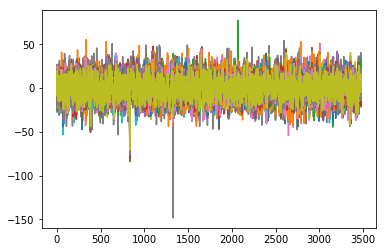

In [0]:
plt.plot(All_trials['Sl_trials'][451]['data'][1,:,:]);

## Binary classification 
Разделяем пробы. Сенсорное восприятие против всего остального (Sl2All), Сенсорное относительно Воображения (Sl2Im), Сенсорное относительно воспоминания (Sl2Mem), Воспоминание относительно Воображения (Im2Mem)

In [0]:
np.random.choice(list(All_trials['Sl_trials'].keys()))

465

In [0]:
share = 0.2
num_trials = All_trials['Sl_trials'][420]['data'].shape[0]
np.random.randint(num_trials, size = int(share*num_trials))

array([34, 42, 18, 49, 28, 26, 10, 33,  9, 20, 13])

In [0]:
num_trials = 50
val_trial_ids  = np.random.randint(num_trials, size = int(share*num_trials))
#list(set(range(num_trials)).difference(set(val_trial_ids)))

In [0]:
from sklearn.model_selection import train_test_split

def train_val_split(share = 0.2):
    
    """
    split for each person trials to train and validation
    """
   # assert act_type in {'Sl2All','Sl2Im','Sl2Mem', 'Im2Mem'}, 'act_type should be Sl2All or Sl2Im, Sl2Mem, Im2Mem'

    val_ids = {}
    train_ids = {}
    for type_name in list(All_trials.keys()):
        person_val_ids = {}
        person_train_ids = {}
        for person_id in list(All_trials[type_name].keys()):
            num_trials = All_trials[type_name][person_id]['data'].shape[0]
            val_trial_ids  = np.random.randint(num_trials, size = int(np.ceil(share*num_trials)))
            #if len(val_trial_ids)==0:
            #    print('Validation ', type_name, person_id)
            train_trial_ids = list(set(range(num_trials)).difference(set(val_trial_ids)))
            if len(train_trial_ids)==0:
                print(type_name, person_id)
            person_val_ids[person_id]=val_trial_ids
            person_train_ids[person_id] = train_trial_ids
        val_ids[type_name] = person_val_ids
        train_ids[type_name] = person_train_ids
    return train_ids, val_ids  

train_ids, val_ids = train_val_split(share = 0.2)

In [0]:
def generate_slice(act_type = 'Sl2All', val = False):
    """
    input target_value
    Sl:0
    Im:1
    Mem:2
    """ 
   
    

    assert act_type in {'Sl2All','Sl2Im','Sl2Mem', 'Im2Mem'}, 'act_type should be Sl2All or Sl2Im, Sl2Mem, Im2Mem'
    if act_type == 'Sl2All':
        type_name = np.random.choice(['Sl_trials', 'Im_trials', 'Mem_trials'], p = [0.46, 0.27,0.27 ])
    elif  act_type == 'Sl2Im': 
        type_name = np.random.choice(['Sl_trials', 'Im_trials'])
    elif act_type == 'Sl2Mem':  
        type_name = np.random.choice(['Sl_trials', 'Mem_trials'])
    else:  
        type_name = np.random.choice(['Im_trials', 'Mem_trials'])  
    
    person_id = np.random.choice(list(All_trials[type_name].keys()))
    if val:
        trial_id  = np.random.choice(val_ids[type_name][person_id])
    else:   
        trial_id  = np.random.choice(train_ids[type_name][person_id])

    X = All_trials[type_name][person_id]['data'][trial_id,:,:]
    y = All_trials[type_name][person_id]['target']
    if act_type == 'Im2Mem':
        y = (lambda y: 0 if y == 2 else 1)(y)
    else:
        y = (lambda y: 0 if y == 0 else 1)(y)
        

        
    return  X,y, (type_name, person_id, trial_id)   

def data_generator(batch_size, resample_lens = [512, 1024, 3480], act_type = 'Sl2All', val=False):
    while True:
    
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y,_ = generate_slice(act_type, val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        
        x_small = np.array([resample(i, resample_lens[0]) for i in batch_x])
        x_med = np.array([resample(i, resample_lens[1]) for i in batch_x])
        x = np.array([i for i in batch_x])
        yield ([x_small, x_med, x], y)        
    
    

In [0]:
dg = data_generator(10, val=False)
X,y = next(dg)

In [0]:
X,y = next(dg)

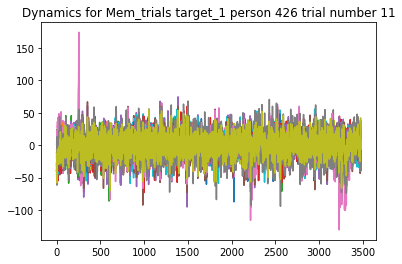

In [0]:
X,y, (type_name, person_id, trial_id)   = generate_slice(act_type = 'Sl2All')
plt.plot(X); plt.title('Dynamics for ' + type_name + ' target_'+str(y)+' person ' +str(person_id)+' trial number ' + str(trial_id));

### Build neural network

In [0]:
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model, load_model
from keras.optimizers import RMSprop, adam

Using TensorFlow backend.


In [0]:
def get_base_model(input_len, fsize):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_seq = Input(shape=(input_len, 19))
    nb_filters = 10
    #nb_filters  = 150
    convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    #compressed = Dense(50, activation="tanh")(processed)
    compressed = Dense(50, activation="tanh")(processed)
    compressed = Dropout(0.3)(compressed)
    #compressed = Dense(20, activation="tanh")(compressed)
    model = Model(inputs=input_seq, outputs=compressed)            
    return model

In [0]:
bm = get_base_model(512, 4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
bm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 19)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 10)           770       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [0]:
def main_model(inputs_lens = [512, 1024, 3480], fsizes = [8,16,24] ):
    input_smallseq = Input(shape=(inputs_lens[0], 19))
    input_medseq = Input(shape=(inputs_lens[1] , 19))
    input_origseq = Input(shape=(inputs_lens[2], 19))
    
    base_net_small = get_base_model(inputs_lens[0], fsizes[0])
    base_net_med = get_base_model(inputs_lens[0], fsizes[1])
    base_net_original = get_base_model(inputs_lens[0], fsizes[2])

    embedding_small = base_net_small(input_smallseq)
    embedding_med = base_net_med(input_medseq)
    embedding_original = base_net_original(input_origseq)
    
    merged = Concatenate()([embedding_small, embedding_med, embedding_original])
    out = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
    
   
    return model

In [0]:
my_model= main_model()

In [0]:
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 19)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1024, 19)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3480, 19)     0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 50)           2080        input_2[0][0]                    
__________________________________________________________________________________________________
model_3 (M

In [0]:
opt = RMSprop(lr=0.005, clipvalue=10**6)
my_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping

nb_epoch = 100000
#nb_epoch = 10
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
samples_per_epoch = 400

my_model.fit_generator(data_generator(batch_size=50, act_type = 'Sl2All', val=False), samples_per_epoch, epochs=nb_epoch, 
                    callbacks=[earlyStopping], verbose=1, validation_steps=100,
                    validation_data=data_generator(batch_size=50, act_type = 'Sl2All', val=True))


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100000
400/400 [==============================] - 306s 766ms/step - loss: 0.7054 - acc: 0.5117 - val_loss: 0.6925 - val_acc: 0.5472
Epoch 2/100000
400/400 [==============================] - 295s 738ms/step - loss: 0.6944 - acc: 0.5267 - val_loss: 0.6899 - val_acc: 0.5400
Epoch 3/100000
400/400 [==============================] - 294s 734ms/step - loss: 0.6571 - acc: 0.5741 - val_loss: 0.5387 - val_acc: 0.7188
Epoch 4/100000
400/400 [==============================] - 291s 729ms/step - loss: 0.5407 - acc: 0.6910 - val_loss: 0.6569 - val_acc: 0.6190
Epoch 5/100000
400/400 [==============================] - 289s 722ms/step - loss: 0.4894 - acc: 0.7133 - val_loss: 0.4476 - val_acc: 0.7444
Epoch 6/100000
400/400 [==============================] - 287s 718ms/step - loss: 0.4456 - acc: 0.7541 - val_loss: 0.5228 - val_acc: 0.6516
Epoch 7/100000
400/400 [==========

In [0]:
%cd /content/gdrive/My\ Drive/Models

my_model.save('Sl2All.h5')

/content/gdrive/My Drive/Models
